# visualizing loss function
Tim Tyre<br>
9.13.2022

In [1]:
from lib.my_initialization import *
from lib import *
#from lib.lib_care.measure.level_sets import comp_longest_level_set_and_smooth
%load_ext autoreload
%autoreload 2

import random,scipy
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import CloughTocher2DInterpolator
from scipy.optimize import minimize
#load libraries for color bar
import matplotlib as mpl #for colorbar
from matplotlib.cm import ScalarMappable
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
#def plotter_3dpoint_cloud_sample(az,...):
from scipy import stats
#DONE: hook this routine up to dask
#DONT: hook this routine up to dask_cuda
# import scanpy as sc
darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
#     theme=cuxfilter.themes.dark
#     #     theme=cuxfilter.themes.rapids
else:
    sns.set_style('white')
#     theme=cuxfilter.themes.light
import warnings
warnings.simplefilter("ignore", UserWarning)
%load_ext autoreload
%autoreload 2
# import cupy as cp
np.random.seed(42)
# cp.random.seed(42)

/Users/timothytyree/opt/miniconda3/envs/pyenv/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#reset matplotlib settings
from mpltools import annotation
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

In [3]:
from lib.lib_care.routines.interp_texture_from_scatter_data import interp_txt_from_scatter

# define module

# TODO: generate table of $a_{max}$ for the best trial in each data run available

$$a_{max} = a_{linear} + 2D$$

for each of the full models
1. iterate over all defect files cached in .parquet files
1. compute the row for the best fit trial

In [4]:
# print("model, run, L, amax/L**2,  rmse, log_likelihood,")
# dict_fit_lst=[]
# # for each of the full models
# for model_str in ['fk','lr']:
#     # for each defect file cached as .parquet files
#     run_num_lst=reversed(range(27))
#     for run_num in run_num_lst:
#         defect_dir=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_fk.parquet'
#         df_defects_fk=pd.read_parquet(defect_dir)
        
        
        
        
# #         dict_fit=dict(model=model_str,run=run,
# #                       L=L,amax=amax,
# #                       rmse=rmse,log_likelihood=log_likelihood,
# #                       alinear=alinear,D=D,r=r,kappa=kappa,
# #                       cluster_index=cluster_index)

In [5]:
# rmse = df_defects_fk['rmse'].min()
# [rmse==df_defects_fk['rmse']]

In [6]:

#compute a row describing the parameter settings of the trial with the lowest error/loss
#HINT: 
df,dict_linear = routine_measure_annihilation_defect(input_fn,printing=True)#,**kwargs)

print(f"{model_str}, {run_num}, {L}, {amax/L**2}, {rmse}, {log_likelihood}")

NameError: name 'input_fn' is not defined

# select data run to visualize

In [11]:
run_num=26 #L=5 cm
# run_num=25 #L=5 cm
# run_num=18 #L=10 cm
parquet_dir_defects_fk=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_fk.parquet'
parquet_dir_defects_lr=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_lr.parquet'
input_folder=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_all'

# load defects and plot the best fits

In [12]:
df_defects_fk=pd.read_parquet(parquet_dir_defects_fk)
df_defects_lr=pd.read_parquet(parquet_dir_defects_lr)
#compute for each member a=amax-2*D
num_digits_round=2
#add columns for amax
df_defects_fk['amax'] = np.around(df_defects_fk['varkappa'] + 2.*df_defects_fk['D'],num_digits_round)
df_defects_lr['amax'] = np.around(df_defects_lr['varkappa'] + 2.*df_defects_lr['D'],num_digits_round)

FileNotFoundError: [Errno 2] No such file or directory: '/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_26_defects_to_fk.parquet'

In [13]:
# parquet_dir_defects_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_26_defects_to_fk.parquet'
# parquet_dir_defects_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_26_defects_to_lr.parquet'
# parquet_dir_defects_fk=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_fk.parquet'
# parquet_dir_defects_lr=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_lr.parquet'
parquet_dir_defects_fk=f'/Users/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_fk.parquet'
parquet_dir_defects_lr=f'/Users/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_lr.parquet'
df_defects_fk=pd.read_parquet(parquet_dir_defects_fk)
df_defects_lr=pd.read_parquet(parquet_dir_defects_lr)
df_defects_lr.shape

#compute for each member a=amax-2*D
num_digits_round=2
#add columns for amax
df_defects_fk['amax'] = np.around(df_defects_fk['varkappa'] + 2.*df_defects_fk['D'],num_digits_round)
df_defects_lr['amax'] = np.around(df_defects_lr['varkappa'] + 2.*df_defects_lr['D'],num_digits_round)

print(f"parameter range supported in run #{run_num}:")
print(df_defects_lr.describe()[['r','kappa','D','varkappa','amax','L']].T[['min','max','count']].T)

#identify the lowest error simulation for each amax value
print(f"\n*******************************")
print(f"* Fenton-Karma Model (best settings):")
print(f"*******************************")
minrmse=9999.
supamax=1.8
for amax,g in df_defects_fk.groupby(by='amax'):
    rmse_min = g['rmse'].min()
    count = g['rmse'].count()
    log_likelihood = g['log_likelihood'].max()
    if (rmse_min<=minrmse)&(amax<=supamax):
        minrmse=rmse_min
        print(f"{amax=:.4f}, {rmse_min=:.4f}, {log_likelihood=:.4f}, {count=}")
        gmin_fk=g.copy()
    

#identify the lowest error simulation for each amax value
print(f"\n*******************************")
print(f"* Luo-Rudy Model (best settings):")
print(f"*******************************")
minrmse=9999.
supamax=10.2
for amax,g in df_defects_lr.groupby(by='amax'):
    rmse_min = g['rmse'].min()
    count = g['rmse'].count()
    log_likelihood = g['log_likelihood'].max()
    if (rmse_min<=minrmse)&(amax<=supamax):
        minrmse=rmse_min
        print(f"{amax=:.4f}, {rmse_min=:.4f}, {log_likelihood=:.4f}, {count=}")
        gmin_lr=g.copy()


parameter range supported in run #26:
                r     kappa           D   varkappa       amax         L
min         0.005     200.0       0.050       0.30       1.78       5.0
max         0.200     980.0       1.295       3.19       3.29       5.0
count  166229.000  166229.0  166229.000  166229.00  166229.00  166229.0

*******************************
* Fenton-Karma Model (best settings):
*******************************
amax=1.7800, rmse_min=0.0768, log_likelihood=18.6331, count=44475

*******************************
* Luo-Rudy Model (best settings):
*******************************
amax=1.7800, rmse_min=3.0439, log_likelihood=-1054.0260, count=44475
amax=2.8900, rmse_min=1.7864, log_likelihood=-333.8867, count=78993
amax=3.2900, rmse_min=1.4036, log_likelihood=-217.5333, count=42761


In [14]:
dg_fk=gmin_fk[gmin_fk['rmse'] == gmin_fk['rmse'].min()]
dg_fk[['cluster_index','job_index']]

,cluster_index,job_index
99022,23278799,215


In [17]:
#find best simulation for the FK model so far
input_folder = f'/Users/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_all'
# input_folder = f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_all'
# cluster_index,job_index = df_defects_fk[df_defects_fk['rmse'] == df_defects_fk['rmse'].min()][['cluster_index','job_index']].values.T
cluster_index,job_index = gmin_fk[gmin_fk['rmse'] == gmin_fk['rmse'].min()][['cluster_index','job_index']].values.T
input_fn = os.path.join(input_folder,f"job.out.{int(cluster_index)}.{int(job_index)}")
assert os.path.exists(input_fn)
input_fn_fk=input_fn


# df_fit_fk,dict_linear_fit_fk = routine_measure_annihilation_defect(input_fn,printing=True)#,**kwargs)
# dict_defects_fk,dict_defects_lr = parse_dict_linear_to_row(dic = dict_linear_fit_fk)
# print(f"best fit for FK has RMSE: {dict_defects_fk['rmse']:.4f} (FK), {dict_defects_lr['rmse']:.4f} (LR)")
# amax_fk=dict_linear_fit_fk['dict_min']['D']*2+dict_linear_fit_fk['dict_min']['varkappa']
# rmse_fk=dict_defects_fk['rmse']
amax_fk=gmin_fk['amax']
rmse_fk=gmin_fk['rmse']



# print(f"best fit of linear particle model fit to FK ({amax=:.4f}):")
# print_dict(dict_linear_fit_fk['dict_min'])
#DONE: find best simulation for the LR model so far
# cluster_index,job_index = df_defects_lr[df_defects_lr['rmse'] == df_defects_lr['rmse'].min()][['cluster_index','job_index']].values.T
cluster_index,job_index = gmin_lr[gmin_lr['rmse'] == gmin_lr['rmse'].min()][['cluster_index','job_index']].values.T
input_fn = os.path.join(input_folder,f"job.out.{int(cluster_index)}.{int(job_index)}")
assert os.path.exists(input_fn)
input_fn_lr=input_fn

df_fit_lr,dict_linear_fit_lr = routine_measure_annihilation_defect(input_fn,printing=True)#,**kwargs)
dict_defects_fk,dict_defects_lr = parse_dict_linear_to_row(dic = dict_linear_fit_lr)
# print(f"best fit for LR has RMSE: {dict_defects_fk['rmse']:.4f} (FK), {dict_defects_lr['rmse']:.4f} (LR)")
# dict_defects_fk
amax_lr=dict_linear_fit_lr['dict_min']['D']*2+dict_linear_fit_lr['dict_min']['varkappa']
# print(f"best fit of linear particle model fit to LR ({amax=:.4f}):")
# print_dict(dict_linear_fit_lr['dict_min'])
# print(f"src: {input_fn}")

#print the best fitting parameter settings
dict_min_fk=dict_linear_fit_fk['dict_min']
dict_min_fk['model']='Fenton-Karma'

dict_min_lr=dict_linear_fit_lr['dict_min']
dict_min_lr['model']='Luo-Rudy'

print(f"\nparameter settings of best fits:")
print(pd.DataFrame((dict_min_fk,dict_min_lr))\
      .drop(columns=['force_code','q','w','no_attraction','no_repulsion','set_second','niter','reflect','Dt','dt','N','CollTime']))

rmse_lr=dict_defects_lr['rmse']
print(f"\nbest fit for Fenton-Karma: RMSE: {rmse_fk:.4f}, amax: {amax_fk:.4f} ")
print(f"{input_fn_fk=}")
print(f"\nbest fit for Luo-Rudy: RMSE: {rmse_lr:.4f}, amax: {amax_lr:.4f} ")
print(f"{input_fn_lr=}")

FileNotFoundError: [Errno 2] No such file or directory: '/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_vidmar_fk_tt.csv'

In [16]:
#plot the original annihilation rates
dict_wjr = recall_death_rates_vidmar_rappel()
fk=dict_wjr['fk']
lr=dict_wjr['lr']
figsize = (6, 4)  #(5,4)
fontsize=18
fig, ax = plt.subplots(figsize=figsize)
df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='k',label='_Best Fit to FK')
df_fit_lr.plot(x='q',y='w',alpha=0.7,ax=ax,color='k',label='_Best Fit to LR')
ax = plot_death_rates_loglog_full(fk,lr,ax=ax,fontsize=fontsize)
# ax.legend(loc='upper left',fontsize=fontsize-2)
ax.legend(loc='lower right',fontsize=fontsize-2.,frameon=False)
#add annotation
xy=(0.3, 11)
# xytext=(0.09, 10)
xytext=(0.01, 70)
ax.annotate(r"best fit ($a>0$)", xy=xy, xytext=xytext,fontsize=fontsize)
#add marker showing the slope of ~2
# annotation.slope_marker(origin=(2.3, 2.0),
#                         slope=2,
#                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                         poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},
#                         ax=ax)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_vidmar_fk_tt.csv'

# line plots of minimum locus traced by constant amax=alinear+2D and increasing D

In [136]:
model_name='Fenton-Karma'
amax=float(amax_fk)
gmin=gmin_fk.sort_values(by='D').copy()

# model_name='Luo-Rudy'
# amax=float(amax_lr)
# gmin=gmin_lr.sort_values(by='D').copy()

gmin.head()

,num_obs,qmin,qmax,rmse,log_likelihood,emin,emax,lemin,lemax,no_repulsion,...,q_hi,N_lo,N_hi,w_lo,w_hi,CollTime_lo,CollTime_hi,cluster_index,job_index,amax
3,19,0.24,0.96,4.341525,-18.848653,-0.150856,10.680337,-0.150856,10.680337,0.0,...,4.0,6.0,100.0,0.231570,606.060606,0.000066,0.172734,22996017,7420,1.78
11768,19,0.24,0.96,49.177964,-41.913567,-0.107489,108.475116,-0.107489,108.475116,0.0,...,4.0,6.0,100.0,0.274937,2000.000000,0.000020,0.145488,22996017,17436,1.78
11779,19,0.24,0.96,6.015207,-22.292509,-0.152411,14.749156,-0.152411,14.749156,0.0,...,4.0,6.0,100.0,0.230015,909.090909,0.000044,0.173902,22996017,7876,1.78
11783,19,0.24,0.96,15.777854,-33.755643,-0.115355,35.080201,-0.115355,35.080201,0.0,...,4.0,6.0,100.0,0.267071,816.326531,0.000049,0.149773,22996017,16236,1.78
11785,19,0.24,0.96,2.903861,-14.252780,-0.149323,6.419529,-0.149323,6.419529,0.0,...,4.0,6.0,100.0,0.233103,353.982301,0.000113,0.171598,22996017,7304,1.78


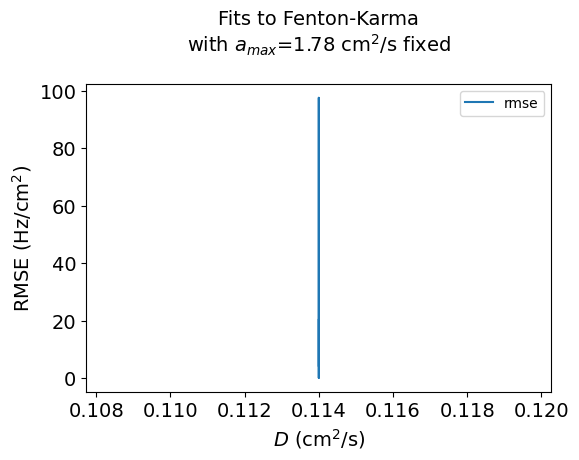

In [137]:
fontsize=14
fig,ax=plt.subplots(figsize=(6,4))
gmin.plot(x='D',y='rmse',ax=ax)
# gmin.plot(x='D',y='log_likelihood')
# gmin.plot(x='D',y='r')
format_plot(ax=ax,xlabel=r'$D$ (cm$^2$/s)',ylabel=r'RMSE (Hz/cm$^2$)',fontsize=fontsize)
ax.set_title("Fits to "+model_name+f'\n'+r'with $a_{max}$='+f'{amax:.2f}'+r' cm$^2$/s'+f' fixed\n',fontsize=fontsize)
plt.show()

# plot loss heatmap in r/L,1/kappa plane 

In [ ]:
print(df_defects_lr.describe()[['r','kappa','D','varkappa','amax','L']].T[['min','max','count']].T)

In [ ]:
amax=1.78 #FK 200x200 diffCoeff=0.0005, src: wj

In [9]:
x1_values,x2_values,y_values=interp_txt_from_scatter(X,y)


NameError: name 'X' is not defined

In [ ]:
#generate 2 coordinate grids for the x & y bounds
num_trials,num_neurons = error_code_array.shape
xcoord_values = np.arange(num_trials+1)  #as corners of pixels
ycoord_values = np.arange(num_neurons+1) #as corners of pixels
x, y = np.meshgrid(xcoord_values, ycoord_values)
y=y[::-1,::-1].copy() #flip y axis
z=spike_count_array.copy().T
zerr=error_code_array.copy().T
x.shape,y.shape,z.shape

In [ ]:
#visualize heatmap showing the number of spikes per trial,neuron pair
# title_str = "All"
title = 'Spike Counts For '
title+= title_str + ' Trials\n'
vmin=1
vmax=150.#np.max(z)
# vmax=np.max(z)
# fontsize=14
# figsize=(16,6)
cmap='jet'#'PuBu_r'#
fig, ax = plt.subplots(figsize=figsize,constrained_layout=True)
ax = GridValuePlotter_colorbar(fig,ax,x,y,z,title,cmap,vmin,vmax,
        fontsize=14,xlabel='Trial',ylabel='Neuron')#,**kwargs)
# ax = GridValuePlotter_colorbar(fig,ax,x,y,z,title,cmap,vmin,vmax,
#                               fontsize=14, xlabel='Trial', ylabel='Neuron', cbar_label='Number of Spikes',
#                               fraction=0.07, shrink=0.85, aspect=35, orientation='horizontal', extend='max')#,**kwargs)
plt.show()

In [ ]:
ax = GridValuePlotter_colorbar(fig,ax,x,y,z,title,cmap,vmin,vmax,
                              fontsize=14, xlabel='Trial', ylabel='Neuron', cbar_label='Number of Spikes',
                              fraction=0.07, shrink=0.85, aspect=35, orientation='horizontal', extend='max')#,**kwargs)

# TODO: visualize the loss function as a stream plot in r,kappa space

# TODO(later): make a sexy 3D plots in r,kappa,alinear space (scaled to L=1)

__Scrum: dev visualization__

1. select dg from df with same amax and neighbors setting
1. for each D in dg plot heat map of r,kappa colored by the Loss function
    - do ibid for Loss=RMSE
    - do ibid for Loss=Neg-Log-Likelihood/Entropy
1. plot the streamplot of the Loss in r,kappa
1. pick a direction to move outward from and measure the increase in Loss as you move away
1. Q: is there a simple functional form in that direction?
1. Q: how does ibid compare to other directions?
